In [1]:
import numpy as np
import cv2
import base64
from io import BytesIO
from PIL import Image

def overlay_heatmap(original_image, heatmap_base64, alpha=0.5):
    """
    Overlay a heatmap on top of an original image.

    Parameters:
    original_image: numpy array or path to image
        The original image to overlay the heatmap on
    heatmap_base64: str
        Base64 encoded string of the heatmap image
    alpha: float
        Transparency of the heatmap overlay (0.0 to 1.0)

    Returns:
    numpy array: The combined image with heatmap overlay
    """
    # Load the original image if path is provided
    if isinstance(original_image, str):
        original_image = cv2.imread(original_image)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Decode base64 heatmap
    try:
        heatmap_bytes = base64.b64decode(heatmap_base64)
        heatmap_buffer = BytesIO(heatmap_bytes)
        heatmap_image = Image.open(heatmap_buffer)
        heatmap_array = np.array(heatmap_image)

        # Convert to RGB if in RGBA format
        if heatmap_array.shape[-1] == 4:
            heatmap_array = cv2.cvtColor(heatmap_array, cv2.COLOR_RGBA2RGB)
    except Exception as e:
        raise ValueError(f"Error decoding heatmap: {str(e)}")

    # Ensure images are the same size
    if original_image.shape[:2] != heatmap_array.shape[:2]:
        heatmap_array = cv2.resize(heatmap_array,
                                 (original_image.shape[1], original_image.shape[0]),
                                 interpolation=cv2.INTER_LINEAR)

    # Convert heatmap to colormap if it's grayscale
    if len(heatmap_array.shape) == 2 or heatmap_array.shape[2] == 1:
        heatmap_array = cv2.applyColorMap(heatmap_array, cv2.COLORMAP_JET)
        heatmap_array = cv2.cvtColor(heatmap_array, cv2.COLOR_BGR2RGB)

    # Blend images
    overlay = cv2.addWeighted(original_image, 1-alpha, heatmap_array, alpha, 0)

    return overlay


'\n# Load image and create/load heatmap\noriginal_img = cv2.imread(\'original.jpg\')\nheatmap_base64 = "..." # Your base64 encoded heatmap string\n\n# Create overlay\nresult = overlay_heatmap(original_img, heatmap_base64, alpha=0.6)\n\n# Optionally convert result to base64\nresult_base64 = save_overlay_as_base64(result)\n'

In [3]:
import numpy as np
import cv2
import base64
from io import BytesIO
from PIL import Image

def generate_mock_heatmap(width=640, height=480, pattern="gaussian"):
    """
    Generate a mock heatmap and convert it to base64.

    Parameters:
    width: int
        Width of the heatmap
    height: int
        Height of the heatmap
    pattern: str
        Type of pattern to generate ("gaussian", "gradient", or "circles")

    Returns:
    str: Base64 encoded string of the heatmap
    numpy.ndarray: The original heatmap array for visualization
    """
    # Create base array
    heatmap = np.zeros((height, width), dtype=np.uint8)

    if pattern == "gaussian":
        # Create Gaussian peaks
        num_peaks = np.random.randint(3, 7)
        for _ in range(num_peaks):
            x = np.random.randint(0, width)
            y = np.random.randint(0, height)
            sigma = np.random.randint(30, 100)
            amplitude = np.random.randint(150, 255)

            y_coords, x_coords = np.mgrid[0:height, 0:width]
            gaussian = amplitude * np.exp(-((x_coords - x) ** 2 + (y_coords - y) ** 2) / (2 * sigma ** 2))
            heatmap = np.maximum(heatmap, gaussian.astype(np.uint8))

    elif pattern == "gradient":
        # Create a diagonal gradient
        x_coords, y_coords = np.meshgrid(np.linspace(0, 255, width), np.linspace(0, 255, height))
        heatmap = ((x_coords + y_coords) / 2).astype(np.uint8)

    elif pattern == "circles":
        # Create concentric circles
        center_x, center_y = width // 2, height // 2
        y_coords, x_coords = np.mgrid[0:height, 0:width]
        distances = np.sqrt((x_coords - center_x) ** 2 + (y_coords - center_y) ** 2)
        heatmap = (np.cos(distances * 0.05) * 127 + 128).astype(np.uint8)

    # Apply colormap
    colored_heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Convert to PIL Image
    colored_heatmap_rgb = cv2.cvtColor(colored_heatmap, cv2.COLOR_BGR2RGB)
    heatmap_image = Image.fromarray(colored_heatmap_rgb)

    # Convert to base64
    buffer = BytesIO()
    heatmap_image.save(buffer, format="PNG")
    base64_string = base64.b64encode(buffer.getvalue()).decode()

    return base64_string, colored_heatmap_rgb

# Example usage with the previous overlay function:
def demo_heatmap_overlay(image_path, pattern="gaussian"):
    """
    Demonstrate the heatmap overlay with a mock heatmap.

    Parameters:
    image_path: str
        Path to the original image
    pattern: str
        Type of heatmap pattern to generate

    Returns:
    numpy.ndarray: The final overlaid image
    """
    # Load original image
    original_image = cv2.imread(image_path)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Generate mock heatmap
    heatmap_base64, _ = generate_mock_heatmap(
        width=original_image.shape[1],
        height=original_image.shape[0],
        pattern=pattern
    )

    # Use the previous overlay_heatmap function
    result = overlay_heatmap(original_image, heatmap_base64, alpha=0.6)

    return result

"""
# Example usage:

# Generate just the heatmap
heatmap_base64, heatmap_array = generate_mock_heatmap(640, 480, pattern="gaussian")

# Or create a complete demo with an image
image_path = "your_image.jpg"
result = demo_heatmap_overlay(image_path, pattern="gaussian")

# Display result using matplotlib
import matplotlib.pyplot as plt
plt.imshow(result)
plt.axis('off')
plt.show()
"""

'\n# Example usage:\n\n# Generate just the heatmap\nheatmap_base64, heatmap_array = generate_mock_heatmap(640, 480, pattern="gaussian")\n\n# Or create a complete demo with an image\nimage_path = "your_image.jpg"\nresult = demo_heatmap_overlay(image_path, pattern="gaussian")\n\n# Display result using matplotlib\nimport matplotlib.pyplot as plt\nplt.imshow(result)\nplt.axis(\'off\')\nplt.show()\n'

In [4]:
heatmap_base64, _ = generate_mock_heatmap(640, 480, pattern="gaussian")

In [5]:
print(heatmap_base64)

iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAIAAAC6s0uzAACzqUlEQVR4nO2965bbOqytiexSeue8db/1Sa/lZPUPl1UULhMTJCXLLmF4KCAIXiSR/AxKrvwQ+X/lkgmy1B0WLhkp6dFVlL4E9v/1XRaRX3Gyqttk2i91QvZ6pHJrjm2yVZQefX7Hyapuk+1H/j+iZ27vlZIescIkXUvV4SRCDqld5bA+HHmyZ7iwp5DrQhwj1euc0hcXdEsp3f1CYLIwGl2y8kaSweLp4h0f8j8f/7XJv39+bLJd+lQB/FvkV5Bc9d8iYvTfj260ujmFr77pPEWvZWtftnqrLJB8S1BKsoKgqpeWp6+Nx3TgnVp5PbmuyxQ5/jJmCPKBvXhJ+/nw4ceQGCiRcYDBK2iXx4q/uEv/h4jI7XHut49FROR/H2CeSF9FXBe9LXfV3Wjl1rL1wzmpL7+2fJt08dnCmAHzHnJyQj99VTygA+/RxBTp7ueEMfwq1+ilxb3IES8j/zRLGjqJURjuGvqOQ5cEc4XBd+jeQdseWyWSLwbLIg8S3z6WTxiP0xcTFyj23moeAwY/zmlTciQIxlku0fmqTi7PXRL3bv3V62fksD5UG3JmxBmu16vLftfQorRN2qNbUOlEb0H02cHjanAcfFburtAF9FUkXrnb6p8MlmWFsSZx9JGMvq0SEdfe2/bO3LZJYXC2FgB70dIk7VE52IIT5YSEvtB7tprP1uigOH1+xdN4AwHBDrgj+GYpEqs6bdL9fDi8JnELoDvG4P/5+O+OWxe9fBBs0dsev5SP5fax/F0CDEfPeiP6WhjfewGQrPQvFOIgmNyLxuQDuYtXZ1rqVeSJK+GuTb8Bd98ZUu98bueQ7ivsonRN2qNbMOKu2xyx+RzFqb+83F9eVoRkr/IWvSmDWyWSiMGt8vmJMCyeLjF9LXSjIJh5NvzJYHfLtznLjfFZQfCrUPlC73PrPL6JE8n3Otsd5CRfAxWJl0CX

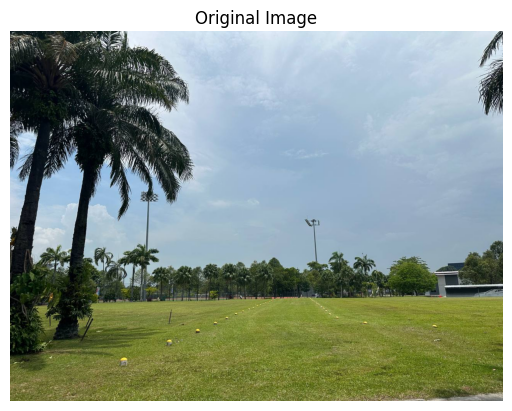

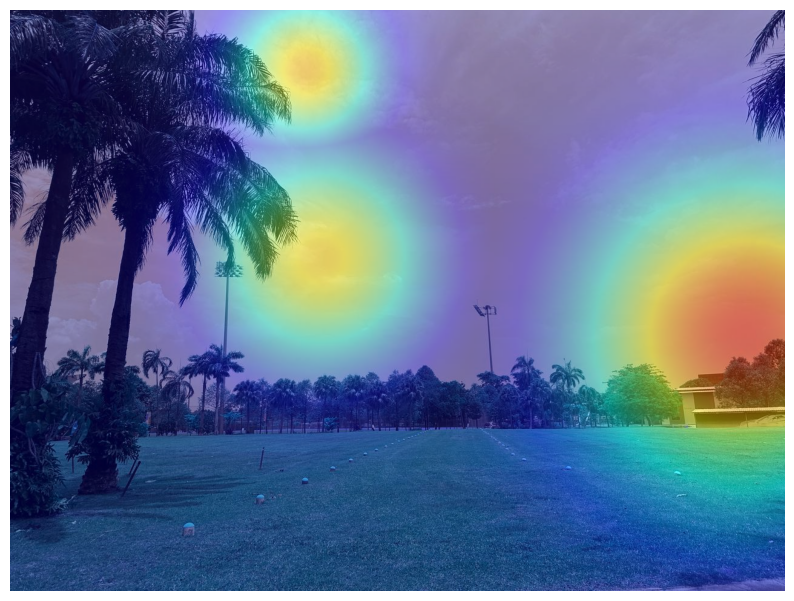

In [11]:
import matplotlib.pyplot as plt


image_path = '/Users/weimingchin/Desktop/term 7/Spatial Design/spatialworld/src/features/Admin_home/HomeContent/images/base_inpaint.jpg'
original_img = cv2.imread(image_path)

# Convert from BGR to RGB for proper colors
original_img_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(original_img_rgb)
plt.axis('off')  # Hide axes for better visualization
plt.title("Original Image")
plt.show()


result = overlay_heatmap(original_img, heatmap_base64, alpha=0.4)
plt.figure(figsize=(10, 8))
plt.imshow(result)
plt.axis('off')
plt.show()